In [1]:
from transformers import AutoModel, AutoTokenizer

checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cpu"  # for GPU usage or "cpu" for CPU usage

tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(device)

In [2]:
import pandas as pd
df = pd.read_csv('../data/camel_data2.csv', header=0)

In [3]:
len(df)

85685

In [4]:
token_len = []


[token_len.append(len(tokenizer.encode(row['snippet']))) for index, row in df.iterrows()]  

Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 512). Running this sequence through the model will result in indexing errors


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [5]:
count_512_or_less = sum(1 for length in token_len if length <= 512)
total_count = len(token_len)
proportion_512_or_less = count_512_or_less / total_count

print(f'512トークン以下の割合: {proportion_512_or_less:.2f}')

512トークン以下の割合: 0.77


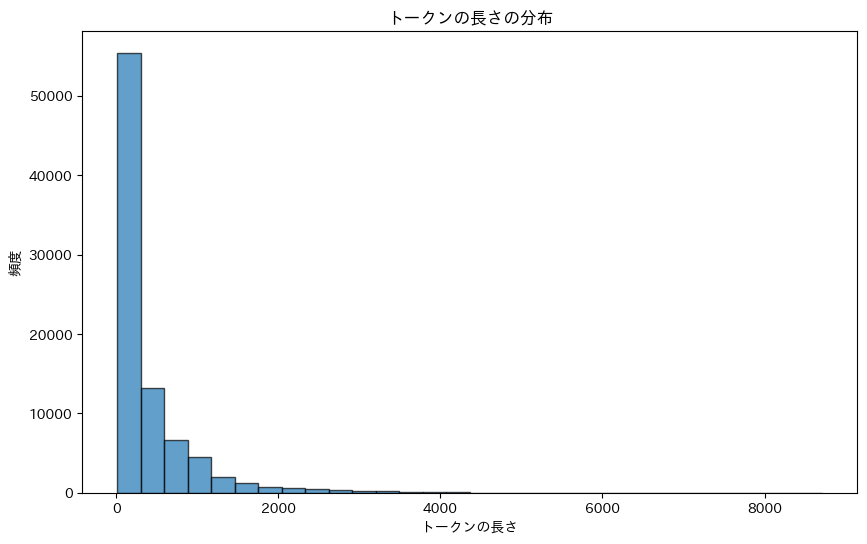

In [6]:
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10, 6))
plt.hist(token_len, bins=30, edgecolor='k', alpha=0.7)
plt.title('トークンの長さの分布')
plt.xlabel('トークンの長さ')
plt.ylabel('頻度')
plt.show()

In [7]:
import torch
# Calculate token lengths and store them in a new column
df['token_len'] = df['snippet'].apply(lambda x: len(tokenizer.encode(x)))


# Filter the DataFrame to keep only records where token length is 512 or less
df_filtered = df[df['token_len'] <= 512]

In [8]:
len(df_filtered['commit_id'].unique())

10890

In [9]:
import math


In [10]:
split_commit_id = df_filtered['commit_id'].unique()[math.floor(len(df_filtered['commit_id'].unique())*0.8)]
split_commit_id
df_filtered[df_filtered['commit_id'] == split_commit_id].index

# その commit_id の最初の出現インデックスを取得
split_index = df_filtered[df_filtered['commit_id'] == split_commit_id].index[0]

# インデックスを基準に train と test を分割するカラムを追加
df_filtered['kinds'] = df_filtered.index.map(lambda idx: 'train' if idx <= split_index else 'test')

C:\Users\masak\AppData\Local\Temp\ipykernel_59544\50908938.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['kinds'] = df_filtered.index.map(lambda idx: 'train' if idx <= split_index else 'test')


In [11]:
df_filtered.head()

,commit_id,snippet,is_defect,token_len,kinds
0,a4701ac4bf5b50810914796e284b0e3f78a240bc,public static <E> Predicate<E> or(final Predic...,True,192,train
1,a4701ac4bf5b50810914796e284b0e3f78a240bc,public static <E> Predicate<E> and(final Predi...,True,192,train
2,a4701ac4bf5b50810914796e284b0e3f78a240bc,public ProcessorBuilder<E> to(Endpoint<E> endp...,True,117,train
3,a4701ac4bf5b50810914796e284b0e3f78a240bc,public Predicate<E> headerEquals(final String ...,True,161,train
4,a4701ac4bf5b50810914796e284b0e3f78a240bc,public DestinationBuilder<E> from(Endpoint<E> ...,True,88,train


In [17]:
len(df_filtered)

65867

In [18]:
df_filtered['kinds'].value_counts()

kinds
test     35863
train    30004
Name: count, dtype: int64

In [14]:
df_filtered['is_defect'].value_counts() / len(df_filtered)


is_defect
True     0.692744
False    0.307256
Name: count, dtype: float64

In [15]:
df_filtered = df_filtered.drop(columns=['token_len'])

df_filtered.to_csv('camel_filtered_data2.csv', index=False)